# Supervised Learning with `PyTorch`

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

**[PyTorch](https://pytorch.org/) is a popular open-source machine learning framework developed by Facebook's AI Research team. It is built to provide flexibility and speed to researchers and developers working on deep learning projects.** 

**PyTorch offers an intuitive and Pythonic interface that enables easy construction and training of complex neural networks. It supports dynamic computational graphs that allow users to modify their networks on the fly during runtime, making it easy to experiment with different architectures and optimize performance.** 

**PyTorch also offers a rich set of tools and utilities for data preprocessing, model evaluation, and deployment. It has gained significant traction in the deep learning community due to its ease of use, speed, and flexibility.**


![torch](https://user-images.githubusercontent.com/42931974/68615320-d6bf3380-04e8-11ea-84f8-dcef049f1ed3.gif)

**In this tutorial, we will implement a neural network, not from scratch, but using PyTorch. We will be training our network via `supervised learning`.**

**PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html), [TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html), all of which include datasets. For this tutorial, we will be using a TorchVision dataset.**

**The `torchvision.datasets` module contains `Dataset` objects for many real-world vision data like CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html), or just use `dir(datasets)`).**

**In this tutorial, we use the `Fashion_MNIST dataset`. Every TorchVision `Dataset` includes two arguments: `transform` and `target_transform` to modify the samples and labels respectively.**


In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



C:\Users\CWLINK\AppData\Roaming\Python\Python39\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**We get the same dataset we used in the previous notebook.**

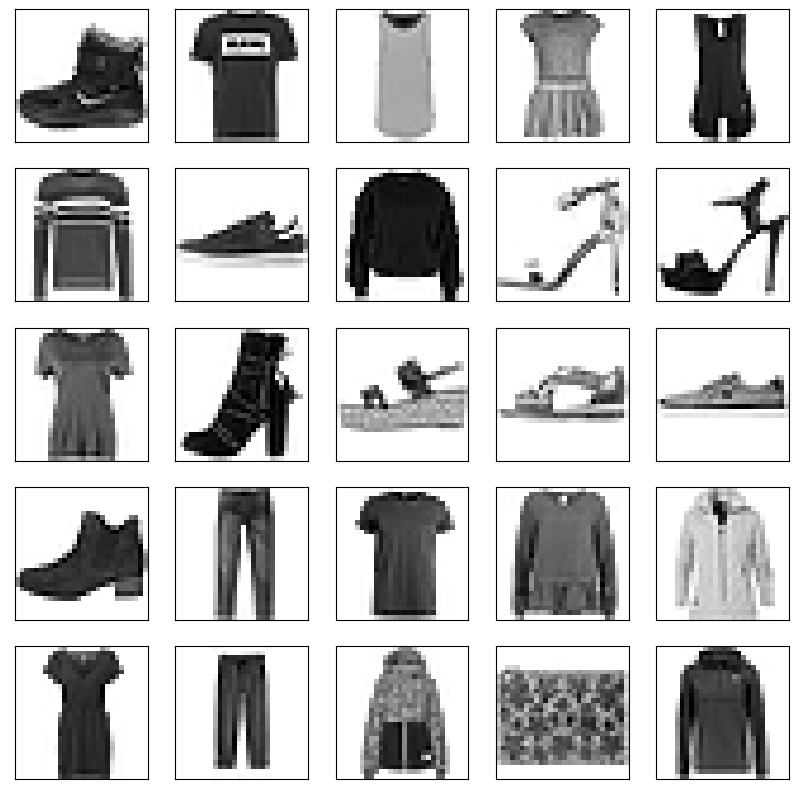

In [2]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(torch.squeeze(training_data[i][0]), cmap=plt.cm.binary)

plt.show()

**PyTorch has its own methods. For example, here we will pass the `Dataset` as an argument to a `DataLoader`. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e., each element in the `DataLoader` iterable will return a batch of 64 images and labels.**

In [3]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f'Sixe of train_data: {len(train_dataloader.dataset)}')
    print(f'Sixe of test_data: {len(test_dataloader.dataset)}')
    print(f'Shape of X [Batch, Channels, Height, Width]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Sixe of train_data: 60000
Sixe of test_data: 10000
Shape of X [Batch, Channels, Height, Width]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


**Neural networks in PyTorch are usually built using classes, inducing the user to OOP (`object oriented programming`).**

**To define a neural network in PyTorch, we create a class that inherits from `nn.Module`. We define the layers of the network in the `__init__` function and specify how data will pass through the network in the `forward` function. To accelerate operations in the neural network, we move it to the GPU if available.**

In [4]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)



Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


**Just as before, to train a model, we need a `loss function` and an `optimizer`. In a single training loop, the model makes predictions on the training dataset (fed to it in batches) and backpropagates the prediction error to adjust the model’s parameters.**

**We will also create a function to train our model after training.**


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'>> Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n>> Accuracy: {(100*correct):>0.1f}%\n>> Avg loss: {test_loss:>8f} \n")


**The training process is conducted over several iterations (_epochs_). During each epoch, as usual, the model learns new parameters to make better predictions.**


In [6]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n--------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)


Epoch 1
--------------------------------
>> Loss: 2.310087  [    0/60000]
>> Loss: 2.303157  [ 6400/60000]
>> Loss: 2.301743  [12800/60000]
>> Loss: 2.301999  [19200/60000]
>> Loss: 2.295810  [25600/60000]
>> Loss: 2.292148  [32000/60000]
>> Loss: 2.287180  [38400/60000]
>> Loss: 2.280199  [44800/60000]
>> Loss: 2.289871  [51200/60000]
>> Loss: 2.283450  [57600/60000]
Test Error: 
>> Accuracy: 17.8%
>> Avg loss: 2.277279 

Epoch 2
--------------------------------
>> Loss: 2.280858  [    0/60000]
>> Loss: 2.277873  [ 6400/60000]
>> Loss: 2.268290  [12800/60000]
>> Loss: 2.274369  [19200/60000]
>> Loss: 2.269529  [25600/60000]
>> Loss: 2.256106  [32000/60000]
>> Loss: 2.261908  [38400/60000]
>> Loss: 2.247182  [44800/60000]
>> Loss: 2.253266  [51200/60000]
>> Loss: 2.245048  [57600/60000]
Test Error: 
>> Accuracy: 38.4%
>> Avg loss: 2.237958 

Epoch 3
--------------------------------
>> Loss: 2.243332  [    0/60000]
>> Loss: 2.240889  [ 6400/60000]
>> Loss: 2.219155  [12800/60000]
>> Los

**Just like in Keras, we can save and load our model pretty easily.**

**A common way to save a model is to serialize the internal state dictionary (containing the model parameters). The process for loading a model includes re-creating the model structure and loading the state dictionary into it.**


In [7]:
torch.save(model.state_dict(), 'fashion_model.pth')
model = NeuralNetwork()
model.load_state_dict(torch.load('fashion_model.pth'))


<All keys matched successfully>

**This model can now be used to make predictions. Our trained model outputs raw prediction `logits`. To convert them to a probability distribution, we can use (just like before) a `softmax function`.**


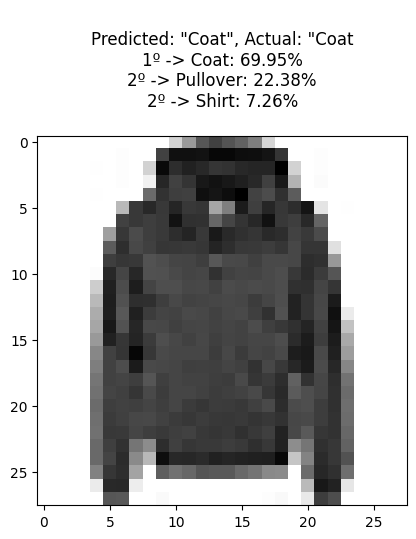

In [8]:
import torch.nn.functional as nnf
import numpy as np

model.eval()

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

sample = np.random.randint(0, 9999)
x, y = test_data[sample][0], test_data[sample][1]

with torch.no_grad():
    pred = model(x)

prob = nnf.softmax(pred, dim=1)

top_p, top_class = prob.topk(3, dim=1)

predicted, actual = classes[top_class[0][0]], classes[y]

plt.imshow(torch.squeeze(test_data[sample][0]), cmap=plt.cm.binary)
plt.title(f'''
Predicted: "{predicted}", Actual: "{actual}
1º -> {classes[top_class[0][0]]}: {(top_p[0][0]*100):>0.2f}%
2º -> {classes[top_class[0][1]]}: {(top_p[0][1]*100):>0.2f}%
2º -> {classes[top_class[0][2]]}: {(top_p[0][2]*100):>0.2f}%
''')
plt.show()


**Pytorch gives the user greater visibility to much of what the Keras/Tensorflow library hides. However, in the end, both frameworks make sure the job gets done, and which one you choose to use (_you will probably use both if you want to practice ML_) is a matter of taste and preference!** 🙃

---

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).
